# Machine Learning-Based Regression Framework to Predict Health Insurance Premiums - PMC

Dataset Source: https://www.kaggle.com/datasets/kanzariachref/medical-insurance-cost-dataset

Note: The original dataset does not have "headers" we added these headers post download

age
gender
bmi
children
smoker
region
insurance_price

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

Loading the dataset and checking for cleanliness of data

Data is already almost clean but the smoker and age have a value of ? in the mix. Lets replace the ? by the mode for smoker and mean for age

In [ ]:
df = pd.read_csv('Medical-Insurance.csv')

df['smoker'] = df['smoker'].replace('?', np.nan)
df['smoker'] = df['smoker'].fillna(df['smoker'].mode()[0]).astype(int)
df['age'] = df['age'].replace('?', np.nan)
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'] = df['age'].fillna(df['age'].mean())
print(df.head())
print()
print(df.info())
print()
print("No. of null values")
for col in df.columns:
    print(f"{col}: {df[col].isnull().sum()}")

print()

print("No. of NaN values")
for col in df.columns:
    print(f"{col}: {df[col].isna().sum()}")

    age  gender     bmi  children  smoker  region  insurance_price
0  19.0       1  27.900         0       1       3      16884.92400
1  18.0       2  33.770         1       0       4       1725.55230
2  28.0       2  33.000         3       0       4       4449.46200
3  33.0       2  22.705         0       0       1      21984.47061
4  32.0       2  28.880         0       0       1       3866.85520

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2772 non-null   float64
 1   gender           2772 non-null   int64  
 2   bmi              2772 non-null   float64
 3   children         2772 non-null   int64  
 4   smoker           2772 non-null   int64  
 5   region           2772 non-null   int64  
 6   insurance_price  2772 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 151.7 KB
None

No. of null values


# Finding data relation


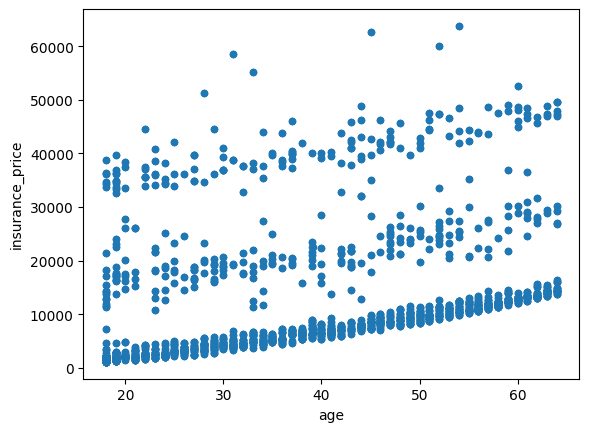

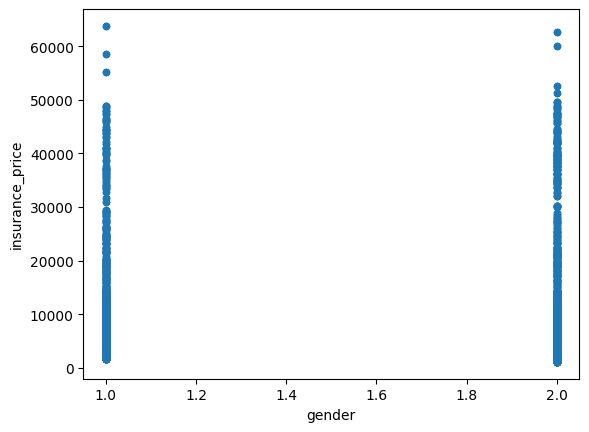

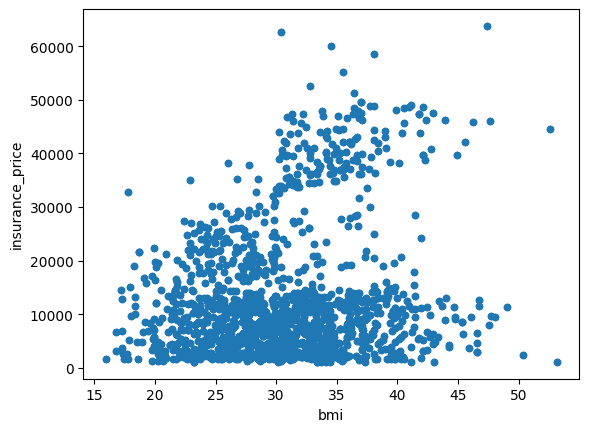

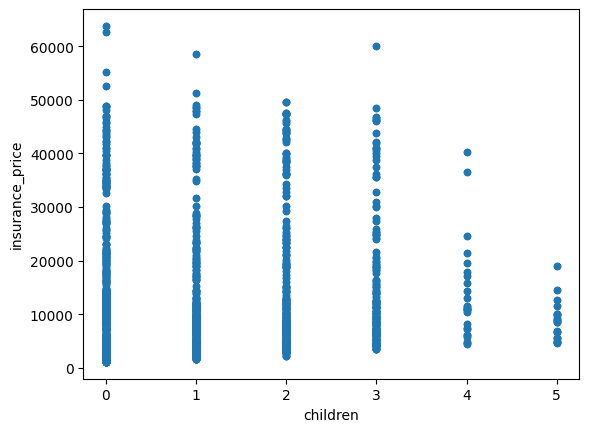

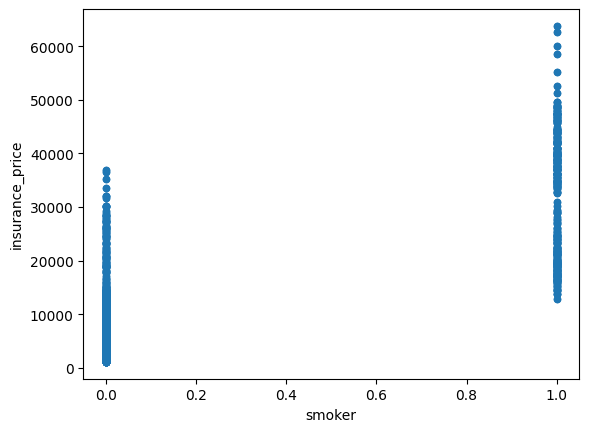

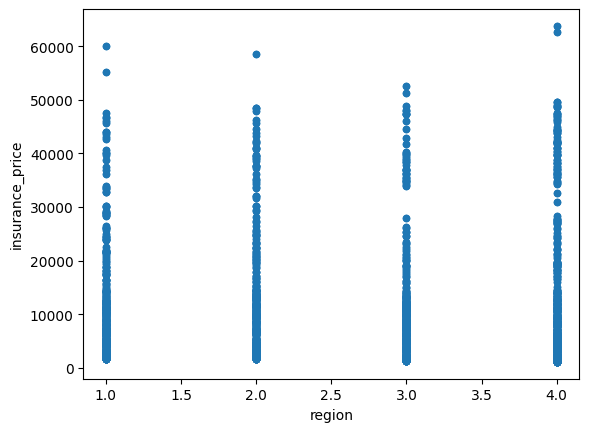

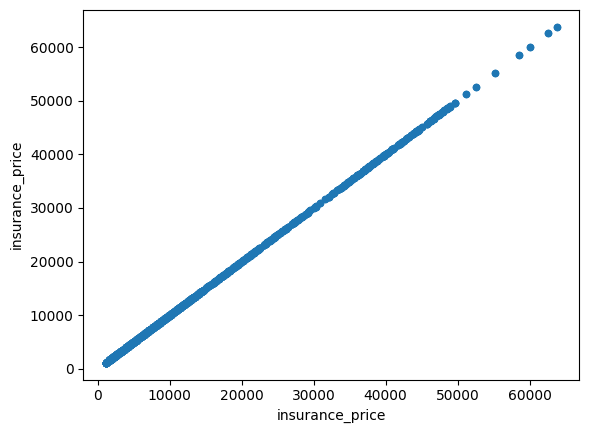

In [ ]:
for col in df.columns:
  df.plot(x=col,y='insurance_price',kind='scatter')

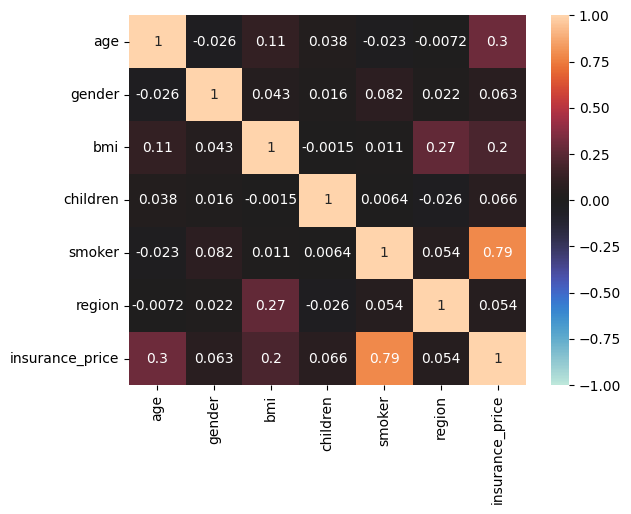

In [ ]:
correlation = df.corr()
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, center=0)
plt.show()

# Split dataset

Split the data from training and

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('insurance_price', axis=1)
y = df['insurance_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training Strategy

Try all combination of features and a subset of hyper parameter tuning using RandomizedSearchCV and get the lowest mean squared error

# KNN Regressor



In [ ]:
import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

least_rmse = float("inf")
best_combination = None
best_params = None
best_knn = None

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

for i in range(1, len(X_train.columns) + 1):
    for feature_combo in itertools.combinations(X_train.columns, i):
        X_train_sel = X_train[list(feature_combo)]
        X_test_sel = X_test[list(feature_combo)]

        knn = KNeighborsRegressor()
        search = RandomizedSearchCV(
            knn,
            param_distributions=param_grid,
            n_iter=10,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train_sel, y_train)

        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test_sel)
        rmse = root_mean_squared_error(y_test, y_pred )

        print(f"Features: {feature_combo}, RMSE: {rmse:.4f}, Params: {search.best_params_}")

        if rmse < least_rmse:
            least_rmse = rmse
            best_combination = feature_combo
            best_params = search.best_params_
            best_knn = best_model

print("\nFinal Results:")
print(f"Best feature combination: {best_combination}")
print(f"Best hyperparameters: {best_params}")
print(f"Lowest RMSE: {least_rmse:.4f}")


Features: ('age',), RMSE: 11957.2948, Params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
Features: ('gender',), RMSE: 14152.0998, Params: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
Features: ('bmi',), RMSE: 12471.4868, Params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
Features: ('children',), RMSE: 12786.9837, Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 11}
Features: ('smoker',), RMSE: 8147.8937, Params: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
Features: ('region',), RMSE: 12686.9987, Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 11}
Features: ('age', 'gender'), RMSE: 11743.2303, Params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
Features: ('age', 'bmi'), RMSE: 6497.6247, Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 11}
Features: ('age', 'children'), RMSE: 11359.1015, Params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11}
Features: ('age', 'smoker'), RMSE: 6742.5867, Params: {'weights': 'distance', 'p': 1, 'n_neighb

# Multiple Linear Regression

In [ ]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

least_rmse = float('inf')
best_combination = None
best_params = None
best_lm = None

param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False]
}

for i in range(1, len(X_train.columns) + 1):
    for feature_combo in itertools.combinations(X_train.columns, i):
        X_train_sel = X_train[list(feature_combo)]
        X_test_sel = X_test[list(feature_combo)]

        lm = LinearRegression()
        search = RandomizedSearchCV(
            lm,
            param_distributions=param_grid,
            n_iter=4,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train_sel, y_train)

        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test_sel)
        rmse = root_mean_squared_error(y_test, y_pred)

        print(f"Features: {feature_combo}, RMSE: {rmse:.4f}, Params: {search.best_params_}")

        if rmse < least_rmse:
            least_rmse = rmse
            best_combination = feature_combo
            best_params = search.best_params_
            best_lm = best_model

print("\n Final Results:")
print(f"Best feature combination: {best_combination}")
print(f"Best hyperparameters: {best_params}")
print(f"Lowest RMSE: {least_rmse:.4f}")


Features: ('age',), RMSE: 11617.9722, Params: {'positive': True, 'fit_intercept': True}
Features: ('gender',), RMSE: 12394.2664, Params: {'positive': True, 'fit_intercept': True}
Features: ('bmi',), RMSE: 12082.5910, Params: {'positive': False, 'fit_intercept': True}
Features: ('children',), RMSE: 12361.0965, Params: {'positive': True, 'fit_intercept': True}
Features: ('smoker',), RMSE: 7843.7887, Params: {'positive': True, 'fit_intercept': True}
Features: ('region',), RMSE: 12384.4669, Params: {'positive': True, 'fit_intercept': True}
Features: ('age', 'gender'), RMSE: 11576.6415, Params: {'positive': True, 'fit_intercept': True}
Features: ('age', 'bmi'), RMSE: 11375.2569, Params: {'positive': True, 'fit_intercept': True}
Features: ('age', 'children'), RMSE: 11603.7577, Params: {'positive': True, 'fit_intercept': True}
Features: ('age', 'smoker'), RMSE: 6692.1282, Params: {'positive': True, 'fit_intercept': True}
Features: ('age', 'region'), RMSE: 11598.9249, Params: {'positive': True

# Support Vector Regression

In [ ]:
import itertools
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

least_rmse = float('inf')
best_combination = None
best_params = None
best_svr = None

param_grid = {
    "kernel": ["rbf", "linear"],
    "C": [1, 10],
    "gamma": ["scale"],
    "epsilon": [0.1, 0.5]
}


for i in range(1, len(X_train.columns) + 1):
    for feature_combo in itertools.combinations(X_train.columns, i):
        X_train_sel = X_train[list(feature_combo)]
        X_test_sel = X_test[list(feature_combo)]

        svr = SVR()
        search = RandomizedSearchCV(
            svr,
            param_distributions=param_grid,
            n_iter=6,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            random_state=42
        )


        search.fit(X_train_sel, y_train)

        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test_sel)
        rmse = root_mean_squared_error(y_test, y_pred)

        print(f"Features: {feature_combo}, RMSE: {rmse:.4f}, Params: {search.best_params_}")

        if rmse < least_rmse:
            least_rmse = rmse
            best_combination = feature_combo
            best_params = search.best_params_
            best_svr = best_model

print("\nFinal Results:")
print(f"Best feature combination: {best_combination}")
print(f"Best hyperparameters: {best_params}")
print(f"Lowest RMSE: {least_rmse:.4f}")


Features: ('age',), RMSE: 12824.4371, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.5, 'C': 1}
Features: ('gender',), RMSE: 12848.1445, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.5, 'C': 1}
Features: ('bmi',), RMSE: 12702.4770, Params: {'kernel': 'linear', 'gamma': 'scale', 'epsilon': 0.1, 'C': 10}
Features: ('children',), RMSE: 12844.7096, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 10}
Features: ('smoker',), RMSE: 10483.4739, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 10}
Features: ('region',), RMSE: 12852.2059, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}
Features: ('age', 'gender'), RMSE: 12824.2860, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}
Features: ('age', 'bmi'), RMSE: 12824.0303, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}
Features: ('age', 'children'), RMSE: 12824.1442, Params: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'C': 1}


# Random Forrest

In [ ]:
import itertools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
import numpy as np

param_dist = {
    "n_estimators": [100, 300, 700, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

least_rmse = float("inf")
best_combination = None
best_params = None
best_rf = None


for i in range(1, len(X_train.columns) + 1):
    for feature_combo in itertools.combinations(X_train.columns, i):
        X_train_sel = X_train[list(feature_combo)]
        X_test_sel = X_test[list(feature_combo)]

        rf = RandomForestRegressor(random_state=42)
        search = RandomizedSearchCV(
            rf,
            param_distributions=param_dist,
            n_iter=10,
            scoring="neg_root_mean_squared_error",
            cv=3,
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train_sel, y_train)

        best_rf_model = search.best_estimator_
        y_pred = best_rf_model.predict(X_test_sel)
        rmse = root_mean_squared_error(y_test, y_pred)

        print(f"Features: {feature_combo}, RMSE: {rmse:.4f}, Params: {search.best_params_}")

        if rmse < least_rmse:
            least_rmse = rmse
            best_combination = feature_combo
            best_params = search.best_params_
            best_rf = best_rf_model

print()
print(f"Best feature combo: {best_combination}")
print(f"Best hyperparams: {best_params}")
print(f"Least RMSE: {least_rmse:.4f}")


Features: ('age',), RMSE: 11517.6148, Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Features: ('gender',), RMSE: 12395.4607, Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Features: ('bmi',), RMSE: 11837.9707, Params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Features: ('children',), RMSE: 12274.2290, Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Features: ('smoker',), RMSE: 7843.7632, Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
Features: ('region',), RMSE: 12370.9749, Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Features: ('age', 'gender'), RMSE: 11380.3100, P

# Cross Validations of models

We can see here that the best random forrest regressor got the highest score

In [ ]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
models = [best_knn, best_lm, best_svr, best_rf]
model_names = [model.__class__.__name__ for model in models]
cv_rmse = {}

for model in models:
  name = model.__class__.__name__
  print(f"Cross Validation of best", f"{model.__class__.__name__}")
  scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
  rmse_scores = np.abs(scores)
  cv_rmse[name] = rmse_scores
  print("RMSE:", [abs(x) for x in scores])
  print("mean", abs(scores.mean()))
  print("std", abs(scores.std()))
  print()

Cross Validation of best KNeighborsRegressor
RMSE: [np.float64(686.7356955582188), np.float64(47.389653872386646), np.float64(647.9474314270827), np.float64(649.8909963703336), np.float64(23.24607686328223)]
mean 411.0419708182608
std 307.18357609836113

Cross Validation of best LinearRegression
RMSE: [np.float64(6180.24373992666), np.float64(5868.801976191302), np.float64(6133.369622273707), np.float64(5984.845927514034), np.float64(6218.355951711045)]
mean 6077.12344352335
std 130.8869918941819

Cross Validation of best SVR
RMSE: [np.float64(12731.737442439638), np.float64(12469.697067839857), np.float64(13370.818621856683), np.float64(12383.491367522427), np.float64(13057.998763841248)]
mean 12802.748652699973
std 368.67295274545336

Cross Validation of best RandomForestRegressor
RMSE: [np.float64(1930.5332723107342), np.float64(1585.9082785063622), np.float64(1754.705573739293), np.float64(1904.1988094529452), np.float64(1617.843948798921)]
mean 1758.6379765616512
std 141.710916593

In [ ]:
print("Pairwise Statistical Significance (p-values):\n")
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        model1 = model_names[i]
        model2 = model_names[j]
        t_stat, p_value = ttest_rel(cv_rmse[model1], cv_rmse[model2])
        print(f"{model1} vs {model2}: p-value = {p_value:.4f} {'Significant' if p_value <= 0.05 else 'Not Significant'}")

Pairwise Statistical Significance (p-values):

KNeighborsRegressor vs LinearRegression: p-value = 0.0000 Significant
KNeighborsRegressor vs SVR: p-value = 0.0000 Significant
KNeighborsRegressor vs RandomForestRegressor: p-value = 0.0001 Significant
LinearRegression vs SVR: p-value = 0.0000 Significant
LinearRegression vs RandomForestRegressor: p-value = 0.0000 Significant
SVR vs RandomForestRegressor: p-value = 0.0000 Significant


## Conclusion

After running all experiments, the **RandomForestRegressor** consistently showed the best overall performance among all tested models.  
Using the brute-force feature selection and tuned hyperparameters, the Random Forest achieved a **test RMSE of approximately 2694**, which is significantly lower than all other models.  

While cross-validation reported a lower mean RMSE (~1758), this discrepancy is expected since cross-validation averages multiple random splits, while the single test RMSE represents performance on one specific split.  

Interestingly, the **KNeighborsRegressor** showed an unusually low cross-validation RMSE(~411) compared to its test performance. This occurs because KNN is **highly sensitive to data distribution and scaling**, small variations in the training folds can produce optimistic results if similar samples appear in both the training and validation splits. In other words, the KNN model likely **benefited from data leakage-like overlap** during cross-validation or from clusters of similar points that reduced the effective difficulty of prediction in those folds. When evaluated on the full unseen test set, where such patterns were less aligned, the true error surfaced at around **4272 RMSE**.  

Meanwhile, **LinearRegression** and **SVR** both performed poorly, with high RMSE values and unstable results across folds, confirming that the relationships in the data are **non-linear** and better captured by ensemble models rather than purely parametric or distance-based approaches.

Overall, the Random Forest provided the most balanced trade-off between bias and variance, maintaining stability across folds while achieving the best predictive accuracy on the test set.  
Therefore, **RandomForestRegressor is the final chosen model** for this experiment. Future improvements may include exploring whether further accuracy gains can be achieved through more complex ensemble techniques.
